In [1]:
import os
import sys
import warnings
import time
from pynq import PL
from pynq import Overlay

BF = os.path.join("./data/system_wrapper.bit")

# Download the bitfile

if not os.path.exists(BF):
    print ("%s Doesn't exist!" % BF)
else:
    print ("Found bit file!")
    
    ol = Overlay(BF)
    ol.download()

    print ("Bitfile downloaded!")

Found bit file!
Bitfile downloaded!


In [2]:
%matplotlib inline
import os,sys,inspect
import argparse
import warnings
import time
from pynq import PL
from pynq import Overlay
from pynq.lib.video import *
from pynq.lib.video.hierarchies import *

currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 

from drivers.video_mixer import VideoMixer
from drivers.dynamic_clock import DynamicClock
from drivers.timing_controller import TimingController
from drivers.test_pattern_generator import TestPatternGenerator
from drivers.test_pattern_generator import TestPatternID
from drivers.axi_graphics import AXIGraphics
from drivers.axi_stream_interconnect import AXISInterconnect
from PIL import Image

DEBUG   = False
ENABLE_VDMA_WRITE = False
ENABLE_VDMA_READ = False

# Instantiate All Cores
print ("Initialize Cores")
ai = AXISInterconnect("video/axis_interconnect_0/xbar")
tc = TimingController("video/timing_generator")
tpg = TestPatternGenerator("video/v_tpg_0")
#vdma_h2c = AxiVDMA(ol.ip_dict["video/axi_vdma_h2c"])
#vdma_c2h = AxiVDMA(ol.ip_dict["video/axi_vdma_c2h"])
ag = AXIGraphics("video/axi_graphics_0")
g0 = ol.low_speed.axi_gpio_0

tc.reset()
while (not tc.is_reset_done()):
    print (".")

WIDTH   = tc.get_generator_width()
HEIGHT  = tc.get_generator_height()

vm = VideoMixer("video/v_mix_0", WIDTH, HEIGHT)

# Configure Sub Window

#SUB_WIN_WIDTH = 1920
#SUB_WIN_HEIGHT = 1080
SUB_WIN_WIDTH = 640
SUB_WIN_HEIGHT = 480
#SUB_WIN_WIDTH = 16
#SUB_WIN_HEIGHT = 4
#SUB_WIN_WIDTH = WIDTH
#SUB_WIN_HEIGHT = HEIGHT

# Configure AXI Stream Routes
ai.set_route(0, 0)  # From VMIX To output screen

# Test Pattern
print ("Configure Test Pattern")
tpg.set_image_size(WIDTH, HEIGHT)
tpg.set_color_format_to_rgb()
#tpg.set_color_bar_test_pattern()
#tpg.set_test_pattern(TestPatternID.SOLID_RED)
#tpg.set_test_pattern(TestPatternID.SOLID_WHITE)
tpg.set_test_pattern(TestPatternID.SOLID_BLACK)
#tpg.set_test_pattern(TestPatternID.COLOR_BARS)
tpg.start()


# Configure VDMA
print ("Configure AXI VDMA")
mode = VideoMode(SUB_WIN_WIDTH, SUB_WIN_HEIGHT, 24)
vdma_h2c = AxiVDMA(ol.ip_dict["video/axi_vdma_h2c"])
vdma_h2c.writechannel.mode = VideoMode(SUB_WIN_WIDTH, SUB_WIN_HEIGHT, 24)
vdma_h2c.writechannel.parked = True
vdma_h2c.writechannel.start()

#vdma_c2h = AxiVDMA(ol.ip_dict["video/axi_vdma_c2h"])
#vdma_c2h.readchannel.reset()

# Configure Video Mixer
print ("Configuring Video Mixer")
vm = VideoMixer("video/v_mix_0", WIDTH, HEIGHT)
vm.configure_layer(1, 0,                        0, SUB_WIN_WIDTH, SUB_WIN_HEIGHT)
vm.enable_layer(1, True)
vm.configure_master_layer(WIDTH, HEIGHT)
vm.start()
vm.enable_master_layer(True)

# GPIO
g0.write(0x0C, 0x01)

# Enable Timing Control
tc.enable(gen_enable = True, use_gen_src = True)

# AXI Graphics
print ("Initialize AXI Graphics Enable")
ag.set_width(SUB_WIN_WIDTH)
ag.set_height(SUB_WIN_HEIGHT)
#ag.set_mode(0)  # Black
#ag.set_mode(1)  # White
#ag.set_mode(2)  # Red
#ag.set_mode(3)  # Green
#ag.set_mode(4)  # Blue
ag.set_mode(5)  # Color Bars
#ag.set_mode(6)  # Block
#ag.set_mode(7)  # Ramp
ag.set_alpha(0xFF)
ag.set_ref0_xy(100, 100)
ag.set_ref1_xy(200, 200)
ag.set_interval(100)
ag.enable_rgba_format(True)
#ag.enable_rgba_format(False)
ag.enable(True)

print ("Color Bars should be on HDMI Display")

Initialize Cores
Configure Test Pattern
Configure AXI VDMA
Configuring Video Mixer
Initialize AXI Graphics Enable
Color Bars should be on HDMI Display


In [3]:
print ("Configure AXI Graphics")
from IPython.display import display, Markdown, clear_output
import ipywidgets as widgets

out = widgets.Output()
#ag.set_alpha(0xFF)
#ag.set_ref0_xy(100, 100)
#ag.set_ref1_xy(200, 200)
#ag.enable(True)

g_dropdown = widgets.Dropdown(
    options = [   ("Black Image", 0),
                  ("White Image", 1),
                  ("Red Image",   2),
                  ("Green Image", 3),
                  ("Blue Image",  4),
                  ("Color Bars",  5),
                  ("Block",       6),
                  ("Ramp",        7)],
    value = 5,
    description = "Mode")

def mode_change_event(change_event):
    global g_dropdown
    if change_event['type'] == 'change' and change_event['name'] == 'value':
        ag.set_mode(g_dropdown.value)
    
g_dropdown.observe(mode_change_event)

widgets.VBox([g_dropdown,out])

Configure AXI Graphics


In [4]:
print ("Enable VDMA Notebook to FPGA")

from IPython.display import display, Markdown, clear_output
import ipywidgets as widgets
from matplotlib.pyplot import imshow
import numpy as np
from PIL import Image


mode = VideoMode(SUB_WIN_WIDTH, SUB_WIN_HEIGHT, 24)
vdma_h2c = AxiVDMA(ol.ip_dict["video/axi_vdma_h2c"])
vdma_h2c.writechannel.mode = VideoMode(SUB_WIN_WIDTH, SUB_WIN_HEIGHT, 24)
vdma_h2c.writechannel.reset()
vdma_h2c.writechannel.parked = True
vdma_h2c.writechannel.start()

# Configure the Video Mixer Channel
vm.configure_layer(2, SUB_WIN_WIDTH,            0, SUB_WIN_WIDTH, SUB_WIN_HEIGHT)
vm.enable_layer(2, True)

send_red_button = widgets.Button(description='Send Red Frame')
send_art_button = widgets.Button(description='Send Art')
out = widgets.Output()

def send_red_button_clicked(_):
    with out:
        print ("Send a Red Frame through VDMA")
        write_frame = vdma_h2c.writechannel.newframe()
        for y in range(write_frame.shape[0]):
            for x in range(write_frame.shape[1]):
                write_frame[y, x, 0] = 0xFF
                write_frame[y, x, 1] = 0x00
                write_frame[y, x, 2] = 0x00
        vdma_h2c.writechannel.writeframe(write_frame)

def send_art_button_clicked(_):
    with out:
        print ("Send Art Frame through VDMA")
        pil_im = Image.open('art.png', 'r')
        write_frame = vdma_h2c.writechannel.newframe()
        write_frame[:] = np.asarray(pil_im)
        vdma_h2c.writechannel.writeframe(write_frame)

send_red_button.on_click(send_red_button_clicked)
send_art_button.on_click(send_art_button_clicked)

widgets_view = widgets.HBox([send_red_button, send_art_button])
widgets.VBox([widgets_view,out])


Enable VDMA Notebook to FPGA


Capture a frame using VDMA Read


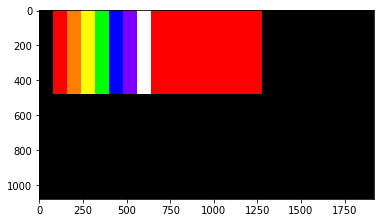

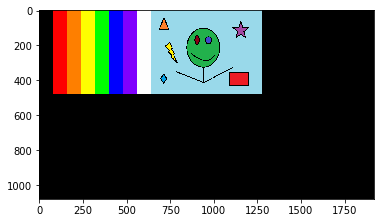

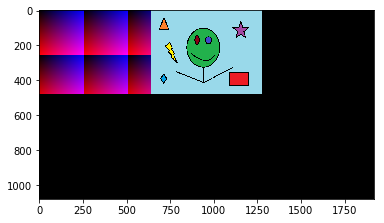

In [5]:
print ("Capture a frame using VDMA Read")
from IPython.display import display, Markdown, clear_output
import ipywidgets as widgets
from matplotlib.pyplot import imshow
import numpy as np
from PIL import Image





button = widgets.Button(description='Capture Image')
out = widgets.Output()
def on_button_clicked(_):
    # "linking function with output"
    with out:
        # what happens when we press the button
        #clear_output()
        print ("Change the route of the AXI Stream Interconnect to route video from the Video Mixer to the Capture VDMA")
        ai.disable_all_routes()
        ai.set_route(0, 1)  # From VMIX To Capture VDMA
        vdma_c2h = AxiVDMA(ol.ip_dict["video/axi_vdma_c2h"])
        vdma_c2h.readchannel.reset()
        vdma_c2h.readchannel.mode = VideoMode(WIDTH, HEIGHT, 24)
        vdma_c2h.readchannel.start()
        frame = vdma_c2h.readchannel.readframe()
        vdma_c2h.readchannel.stop()
        print ("Change the route of the AXI Stream Interconnect to route video from the Video Mixer to the HDMI")
        ai.disable_all_routes()
        ai.set_route(0, 0)  # From VMIX To output screen
        im = Image.fromarray(frame)
        imshow(im)
            
# linking button and function together using a button's method
button.on_click(on_button_clicked)
# displaying button and its output together
widgets.VBox([button,out])